In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import descartes
import csv
import pandas as pd

with open('nodos.csv') as f:
    nodos = pd.read_csv(f)
    
barrios = nodos.NOMBRE[nodos.NOMBRE.duplicated()==False].values
    
DEFAULT_COLOR = {
  1:  '#8dd3c7',
  2:  '#ffffb3',
  3:  '#bebada',
  4:  '#fb8072',
  5:  '#80b1d3',
  6:  '#fdb462',
  7:  '#b3de69',
  8:  '#fccde5',
  9:  '#d9d9d9',
  10: '#bc80bd',
  11: '#ccebc5',
  12: '#ffed6f',
  13: '#b2df8a',
}

DEFAULT_BARRIOS = nodos.NOMBRE[nodos.NOMBRE.duplicated()==False].values

vecinos = {}

DEFAULT_COORDINATES  = {}

for barrio in DEFAULT_BARRIOS:
    nodos_barrio = nodos[nodos.NOMBRE==barrio]
    coordinates_barrio = zip(nodos_barrio.X.values, nodos_barrio.Y.values)
    poligon = Polygon(coordinates_barrio)
    
    DEFAULT_COORDINATES[barrio] = coordinates_barrio


def fitness(gen):
    """Returns a positive number that indicates how close the individual is to our desired solution.
    """    
    gendf = pd.DataFrame(gen)
    mad = gendf.mad()
    
    return mad.std()

# Ver Fitness.ipynb
def visualize(gen, color=DEFAULT_COLOR, barrios=DEFAULT_BARRIOS, coordinates=DEFAULT_COORDINATES, alpha=0.5):
    """Plots a solution for visual interpretation
    """
    plt.rcParams['figure.figsize'] = (20.0, 10.0)

    fig = plt.figure()
    ax = fig.add_subplot(121)
    
    # vamos de gen a barrio, dia. Como se hace?
    # sacamos el barrio, dia de la matriz de gen.
    gis = zip(barrios, coordinates.values()) 
    
    rows, columns = gen.shape

    for row in range(rows):
        for column in range(columns):
            data = gen[row, column]

            if data > 0:
                poly = coordinates[sorted(barrios)[row]]     
                ax.add_patch(descartes.PolygonPatch(Polygon(poly), fc=color[column+1], alpha=alpha))
    
    ax.axis('equal')
    
    ax2 = fig.add_subplot(122)
    gendf = pd.DataFrame(gen)
    gendf.mad().plot.bar()

    plt.show()
    
# Ver MatrizVecinos.ipynb
matriz_vecinos = pd.read_csv('adyacencia.csv', sep=';')

with open('lectura.csv') as f:
    lectura = pd.read_csv(f)
    
DEFAULT_CLIENTES = dict(zip(lectura.GIS, lectura.Clientes))

# Ver Genetic.ipynb
from pyevolve import G2DList
from pyevolve import GSimpleGA
from pyevolve import Selectors
from pyevolve import Crossovers
from pyevolve import Mutators
from pyevolve import GAllele
from pyevolve import Consts

from random import shuffle, randint


def evaluation_function(chromosome):
    # We want to give higher score to those solutions that have small mad.
    chromosome_np = np.asarray([row for row in chromosome])
    chromosome_pd = pd.DataFrame(chromosome_np)
    mad = chromosome_pd.mad()
    error = mad.std()
    
    # We want to give higher score to those solutions
    # that have barrios that are closer to each other
    # Meaning that each barrio should have at least one neighbor in the same day:
    #for dia in chromosome_np.T:
    #    # Iterate over barrios on that day. But first find non null items.
    #    for item in row:
    #        # check that this barrio has a neighbor
    #        #matriz_vecinos[item :]
    #        pass

    return error

def G2DListBarrioInitializator(genome, **args):
    """ The initializator for our problem """
    
    allele = genome.getParam("allele", None)
    
    if allele is None:
        Util.raiseException("to use the G2DListBarrioInitializator, you must specify the 'allele' parameter")

    genome.clearList()

    for i in xrange(genome.getHeight()):
        options = allele[i].options
        active = randint(0, genome.getWidth())
        for j in xrange(genome.getWidth()):
            value = 0
            
            if j == active:
                value = options[i]
                
            genome.setItem(i, j, value)
            
    #shuffle(genome.genomeList)
        

def ga(dias=13, barrios=329, generations=100, freq_stats=10, clientes=DEFAULT_CLIENTES, evaluation=evaluation_function):
    # Genome instance
    genome = G2DList.G2DList(barrios, dias)
    
    # alleles are initialized from client list.
    
    alleles = GAllele.GAlleles()
    ordered_clientes = [clientes[key] for key in sorted(clientes)]
    for i, item in enumerate(ordered_clientes):
        zeros = np.zeros(len(clientes))
        zeros[i] = item
        
        a = GAllele.GAlleleList(zeros)
        alleles.add(a)
    
    genome.setParams(allele=alleles)
    
    # The evaluator function (objective function)
    genome.evaluator.set(evaluation)
    genome.crossover.set(Crossovers.G2DListCrossoverSingleHPoint)
    genome.mutator.set(Mutators.G2DListMutatorSwap)
    genome.initializator.set(G2DListBarrioInitializator)
    

    # Genetic Algorithm Instance
    ga = GSimpleGA.GSimpleGA(genome)
    ga.setGenerations(generations)
    ga.setMutationRate(0.1);
    ga.setMinimax(Consts.minimaxType["minimize"])
    ga.terminationCriteria.set(GSimpleGA.ConvergenceCriteria)

    # Do the evolution, with stats dump
    # frequency of 10 generations
    ga.evolve(freq_stats=freq_stats)
    return ga.bestIndividual()

def ga_to_array(solution):
    return np.asarray([row for row in solution], dtype=np.uint16)

In [11]:
# Cargar matriz de vecinos.

In [12]:
dias = dict(zip(lectura.GIS, lectura.Dia))

initial_solution = np.zeros((len(lectura.GIS), len(lectura.Dia.unique()+1)))


for index, barrio in enumerate(sorted(lectura.GIS)):
    initial_solution[index, dias[barrio]-1] = DEFAULT_CLIENTES[barrio]

## Antes de empezar a generar soluciones mejores que la inicial, grafiquemos el MAD y la ubicación espacial de esa solución

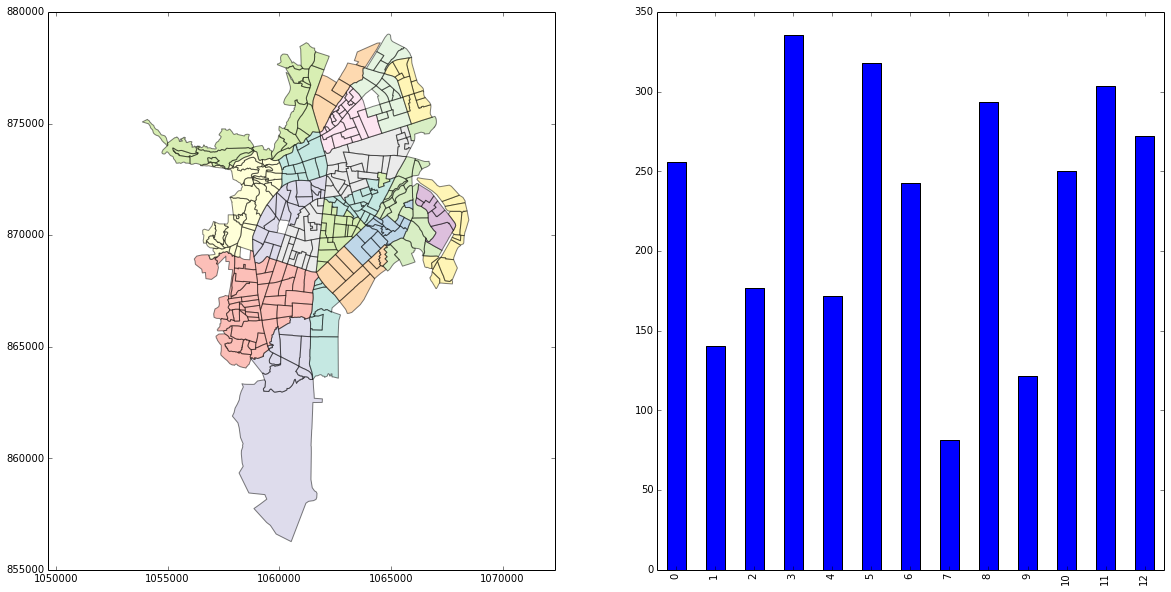

In [13]:
visualize(initial_solution)

In [14]:
def g(generations):
    our_solution_ga = ga(generations=generations, freq_stats=generations/10)
    our_solution = ga_to_array(our_solution_ga)
    visualize(our_solution)
    print pd.DataFrame(our_solution)

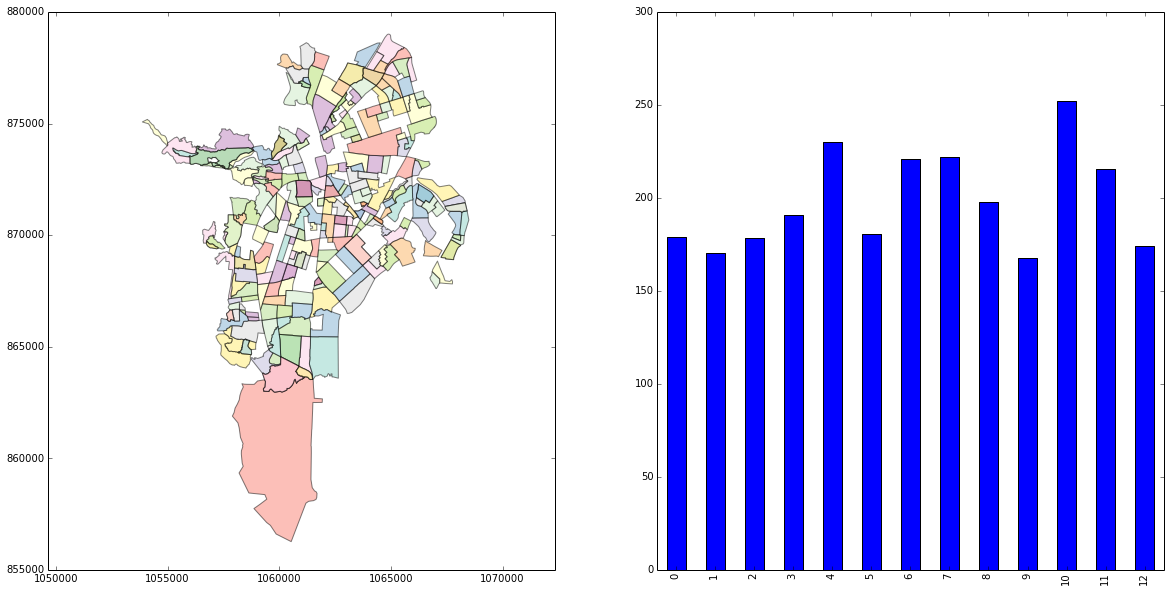

        0     1    2     3     4     5     6     7     8     9     10    11  \
0        0     0    0     0     0     0     0     0     0     0     0     0   
1        0     0    0     0     0     0     0     0     0     0     0     0   
2        0     0    0     0     0     0     0     0     0     0   495     0   
3        0     0    0     0     0     0     0     0     0     0     0     0   
4        0     0    0     0     0     0     0     0     0     0     0  1344   
5        0     0    0     0     0     0     0     0     0  6492     0     0   
6        0     0    0     0     0     0     0     0     0     0     0     0   
7        0     0    0     0     0     0     0  3233     0     0     0     0   
8        0     0    0     0     0     0     0     0     0     0     0     0   
9        0     0    0     0     0     0     0     0     0     0     0     0   
10       0     0    0     0     0     0     0     0     0     0     0     0   
11       0     0    0     0     0     0  3127     0 

In [15]:
%time g(1)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [69.01(92.21)/49.12(32.21)/57.50(57.50)]
Gen. 1 (10.00%): Max/Min/Avg Fitness(Raw) [50.35(59.59)/35.24(27.83)/41.96(41.96)]
Gen. 2 (20.00%): Max/Min/Avg Fitness(Raw) [46.52(61.34)/33.35(22.99)/38.76(38.76)]
Gen. 3 (30.00%): Max/Min/Avg Fitness(Raw) [46.24(59.20)/29.77(15.02)/38.54(38.54)]
Gen. 4 (40.00%): Max/Min/Avg Fitness(Raw) [40.39(48.95)/25.46(15.02)/33.66(33.66)]
Gen. 5 (50.00%): Max/Min/Avg Fitness(Raw) [41.32(49.99)/25.84(15.02)/34.44(34.44)]
Gen. 6 (60.00%): Max/Min/Avg Fitness(Raw) [41.62(50.21)/25.90(15.02)/34.69(34.69)]
Gen. 7 (70.00%): Max/Min/Avg Fitness(Raw) [40.01(46.51)/24.06(15.02)/33.35(33.35)]
Gen. 8 (80.00%): Max/Min/Avg Fitness(Raw) [40.16(50.88)/26.38(15.02)/33.46(33.46)]
Gen. 9 (90.00%): Max/Min/Avg Fitness(Raw) [39.63(56.04)/27.47(13.68)/33.03(33.03)]
Gen. 10 (100.00%): Max/Min/Avg Fitness(Raw) [38.43(46.33)/23.81(13.68)/32.02(32.02)]
Total time elapsed: 5.021 seconds.


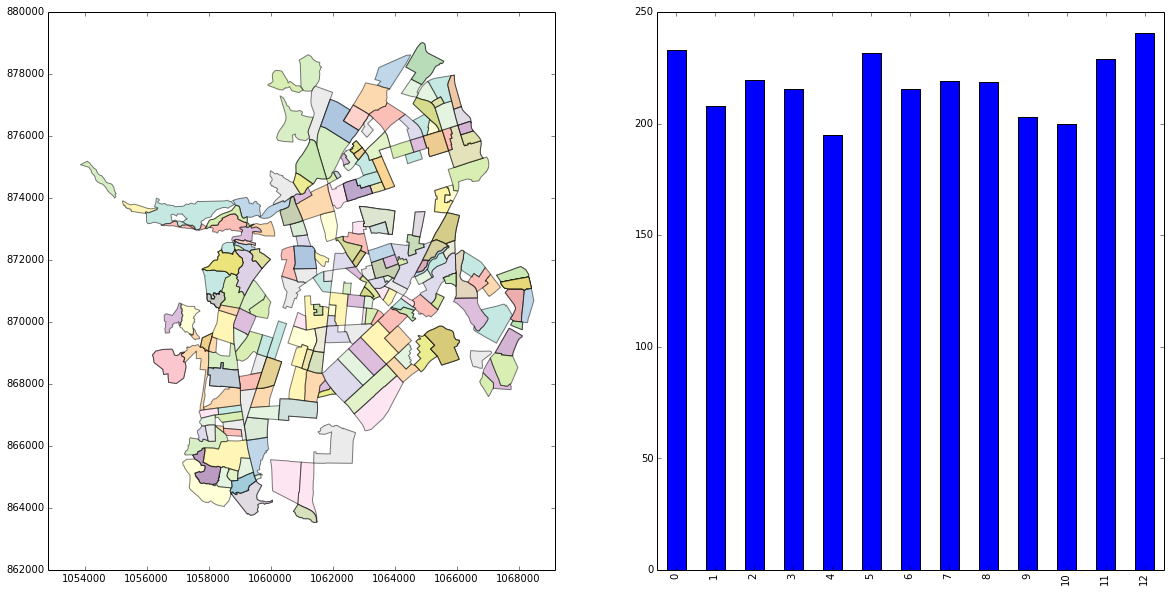

       0     1     2     3     4     5     6     7     8     9     10    11  \
0       0     0     0     0     0     0     0     0     0     0     0  3374   
1       0     0     0     0     0     0     0     0     0   575     0     0   
2       0     0     0     0     0     0     0     0     0     0     0     0   
3       0     0     0     0     0     0     0     0     0  2664     0     0   
4       0     0     0     0     0     0     0     0     0     0     0     0   
5       0     0     0     0     0     0     0     0     0     0     0     0   
6       0     0     0     0     0     0     0     0     0     0     0     0   
7       0     0     0     0     0     0     0     0     0     0  2155     0   
8       0     0     0     0     0     0     0     0  1679     0     0     0   
9       0     0     0     0     0     0     0     0  1833     0     0     0   
10      0     0     0     0     0     0     0     0     0     0     0     0   
11      0     0     0     0     0     0  3127     0 

In [16]:
%time g(10)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [67.90(103.18)/48.14(21.81)/56.59(56.59)]

	A break was detected, you have interrupted the evolution !

Gen. 238 (2.38%): Max/Min/Avg Fitness(Raw) [40.07(54.04)/25.84(10.05)/33.39(33.39)]
Total time elapsed: 112.944 seconds.


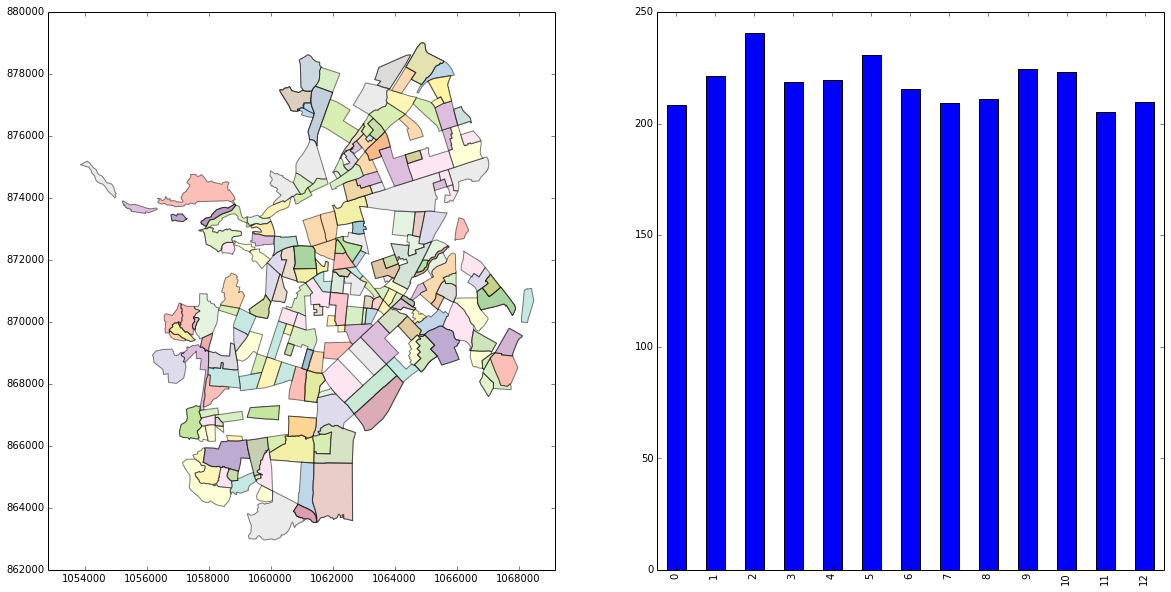

       0     1     2     3     4    5     6     7      8     9     10    11  \
0       0     0     0     0     0    0     0     0      0     0     0   950   
1    1679     0     0     0     0    0     0     0      0     0     0     0   
2       0     0     0     0     0    0     0     0      0     0     0     0   
3       0     0     0     0     0    0     0     0      0     0     0     0   
4       0     0     0     0     0    0     0     0    713     0   452     0   
5       0     0     0  2679     0    0     0     0      0     0     0     0   
6       0     0   997     0     0    0     0     0      0     0     0     0   
7       0     0     0     0     0    0     0     0      0     0     0     0   
8       0     0     0     0     0    0     0     0      0     0     0     0   
9       0     0     0     0     0    0     0     0      0     0     0     0   
10      0     0     0     0     0    0     0   694      0     0     0     0   
11      0     0     0     0     0    0     0     0  

In [17]:
%time g(10000)

In [18]:
visualize(our_solution)

NameError: name 'our_solution' is not defined

 ## First, we create a 'bag' of barrios, similar to picking names from a bag.
 ## Then we take the average of the expected clients per barrio and save it in a variable
 ## Then, we pick the first 13 and put them in different buckets, if one of them is neighbor with the others, we will put it back in the bag. They will seed the process.
 ## Then, we start going one by one, as if they were choosing team mates before a match. For each of the barrios in the 13 buckets, we will look at the neighbour list from the last added barrio and one by one try to get items from the bag. If the sum of all clients in a bucket comes close to 10% (more or less) we stop and switch to the next item.

In [38]:
oo = pd.DataFrame([2, 3, -1, 0])
oo * oo.abs()

,0
0,4
1,9
2,-1
3,0


In [53]:
ojo = oo.where(oo!=0) / oo
np.nan_to_num(ojo)

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 0.]])